In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

In [2]:
gpus = tf.config.list_physical_devices(device_type = 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
class DataLoader:
    def __init__(self):
        AS_dataset = pd.read_csv('./Arbitrary_Single_band_Coupler_Phase_Shift.csv', encoding='utf-8')
        self.X = AS_dataset.loc[:,'freq':'L4'].to_numpy()
        self.y = AS_dataset.loc[:,'S11r':'S41i'].to_numpy()
#         self.mmX = MinMaxScaler()
#         self.X[:,1:] = self.mmX.fit_transform(self.X[:,1:])
#         self.X[:,0] = self.X[:,0] / 10
#         self.X, _, self.y, _ = train_test_split(self.X, self.y, test_size=0.75, random_state=0)
        self.X_train, self.X_vali, self.y_train, self.y_vali = train_test_split(self.X, self.y, test_size=0.1, random_state=0)
        self.num_train = self.X_train.shape[0]
    def get_batch(self, batch_size=0, mode='train'):
        if mode == 'train':
            index = np.random.randint(0, self.num_train, batch_size)
            return self.X_train[index], self.y_train[index]
        if mode == 'validate':
            return self.X_vali, self.y_vali

In [4]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense3 = tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu)
        self.dense4 = tf.keras.layers.Dense(units=256, activation=tf.nn.leaky_relu)
        self.dense5 = tf.keras.layers.Dense(units=8)
    
#     @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.dense5(x)
        return output

In [5]:
num_epochs = 200
batch_size = 256
learning_rate = 0.001

In [7]:
model = MLP()
data_loader = DataLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
X_v, y_v = data_loader.get_batch(mode='validate')

epoch:0
train mse:0.08462287485599518 rmse:0.2909001111984253 mae:0.23335210978984833 r2:0.295413613319397
vali mse:0.09148154407739639 rmse:0.30245915055274963 mae:0.243830606341362 r2:0.24163907766342163
epoch:10
train mse:0.05680103600025177 rmse:0.23832967877388 mae:0.19141827523708344 r2:0.5305585861206055
vali mse:0.0581173412501812 rmse:0.24107538163661957 mae:0.19072432816028595 r2:0.5182206630706787
epoch:20
train mse:0.04348975792527199 rmse:0.20854197442531586 mae:0.16520996391773224 r2:0.6391353607177734
vali mse:0.041443657130002975 rmse:0.20357714593410492 mae:0.1596190631389618 r2:0.6564416289329529
epoch:30
train mse:0.03846195340156555 rmse:0.19611719250679016 mae:0.153875470161438 r2:0.6819158792495728
vali mse:0.037712596356868744 rmse:0.19419731199741364 mae:0.15245358645915985 r2:0.6873712539672852
epoch:40
train mse:0.03148438408970833 rmse:0.1774383932352066 mae:0.13513407111167908 r2:0.7380125522613525
vali mse:0.03224809095263481 rmse:0.1795775294303894 mae:0.1

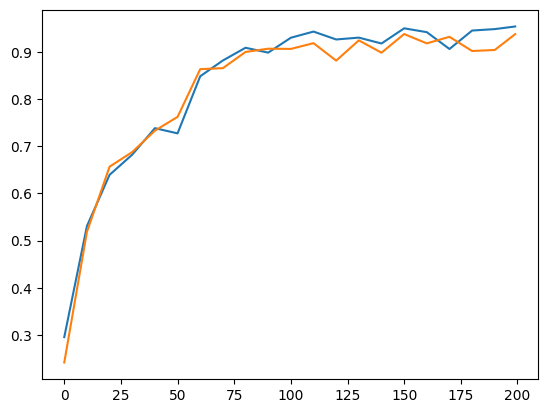

In [8]:
showX = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199]
showY1 = []
showY2 = []

num_batch = data_loader.num_train // batch_size
for epoch_index in range(num_epochs):
    for batch in range(num_batch):
        X, y = data_loader.get_batch(batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X)
            tr_mse = tf.reduce_mean(tf.square(y_pred - y))
        grads = tape.gradient(tr_mse, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    if epoch_index % 10 == 0 or epoch_index == num_epochs - 1:
        tr_rmse = tf.sqrt(tr_mse)
        tr_mae = tf.reduce_mean(tf.abs(y_pred - y))
        tr_r2 = 1 - tf.reduce_sum(tf.square(y_pred - y)) / tf.reduce_sum(tf.square(y - tf.cast(tf.reduce_mean(y), dtype=tf.float32)))
        print("epoch:{}".format(epoch_index))
        print("train mse:{} rmse:{} mae:{} r2:{}".format(tr_mse, tr_rmse, tr_mae, tr_r2))
        y_v_p = model(X_v)
        va_mse = tf.reduce_mean(tf.square(y_v_p - y_v))
        va_rmse = tf.sqrt(va_mse)
        va_mae = tf.reduce_mean(tf.abs(y_v_p - y_v))
        va_r2 = 1 - tf.reduce_sum(tf.square(y_v_p - y_v)) / tf.reduce_sum(tf.square(y_v - tf.cast(tf.reduce_mean(y_v), dtype=tf.float32)))
        print("vali mse:{} rmse:{} mae:{} r2:{}".format(va_mse, va_rmse, va_mae, va_r2))
        showY1.append(tr_r2)
        showY2.append(va_r2)
plt.plot(showX, showY1, showX, showY2)
plt.show()

In [9]:
tf.saved_model.save(model, './models')

INFO:tensorflow:Assets written to: ./models/assets


In [14]:
model = tf.saved_model.load('./models')

In [33]:
def obj_func(s_para):
    E = tf.square(s_para)
    E11 = E[:,0] + E[:,1]
    E21 = E[:,2] + E[:,3]
    E31 = E[:,4] + E[:,5]
    E41 = E[:,6] + E[:,7]
    l1 = E11 - E21 - E31 + E41
    l2 = tf.square(E21 / (E31 + E21) - 3 / 10)
    l3 = tf.square(tf.math.atan2(s_para[:,5], s_para[:,4]) - tf.math.atan2(s_para[:,3], s_para[:,2]) - np.pi / 4)
    l4 = tf.square(tf.reduce_sum(E, axis=1) - 1)
    print(l1, l2, l3, l4)
    loss = l1 + l2 + l3 + l4
    return loss

In [22]:
num_nodes = 5000
num_node_epochs = 500

In [23]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

mmin = np.min(data_loader.X[: , 1: ], axis=0)
mmax = np.max(data_loader.X[: , 1: ], axis=0)

# structure.append(tf.Variable(np.random.uniform(0, 1, (num_nodes, 10)), dtype=tf.float32))
structure = tf.Variable(np.random.uniform(mmin, mmax, (num_nodes, 12)), dtype=tf.float32)

freq1 = tf.ones([num_nodes, 1]) * 2.4
freq2 = tf.ones([num_nodes, 1]) * 2.5
freq3 = tf.ones([num_nodes, 1]) * 2.6

minLoss = 0
minIndex = 0
minS = 0

In [24]:
bestLoss = 10
bestStructure = 0

In [26]:
def check(structure):
    inva_place1 = tf.where(tf.logical_or(structure[:,:8] < 1, structure[:,:8] > 4))
    structure = tf.tensor_scatter_nd_update(structure, [inva_place1], [np.random.uniform(mmin[inva_place1[:,1]], mmax[inva_place1[:,1]], (inva_place1.shape[0]))])
    
    inva_place2 = tf.where(tf.logical_or(structure[:,8:] < 10, structure[:,8:] > 60)) + [0, 8]
    structure = tf.tensor_scatter_nd_update(structure, [inva_place2], [np.random.uniform(mmin[inva_place2[:,1]], mmax[inva_place2[:,1]], (inva_place2.shape[0]))])
    
    return tf.Variable(structure)
    
    # structure[j] = tf.Variable(tf.tensor_scatter_nd_update(structure[j], [nega_place], [np.random.uniform(0, 1, (nega_place.shape[0]))]))

In [27]:
for i in range(num_node_epochs):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(structure)
        y_pred1 = model(tf.concat([freq1, structure], axis=1))
        y_pred2 = model(tf.concat([freq2, structure], axis=1))
        y_pred3 = model(tf.concat([freq3, structure], axis=1))
        loss = obj_func(y_pred1) + obj_func(y_pred2) + obj_func(y_pred3)
    minLoss = tf.reduce_min(loss).numpy()
    minIndex = tf.argmin(loss).numpy()
    minS = structure[minIndex].numpy()
    grads = tape.gradient(loss, structure)
    opt.apply_gradients(grads_and_vars=zip([grads], [structure]))
    structure = check(structure)
    if minLoss < bestLoss:
        bestLoss = minLoss
        bestStructure = minS
        # bestStructure = data_loader.mmX.inverse_transform([minS[0]])[0]
        print(minIndex)
        print(i, bestLoss)
        print(bestStructure)
        print()

1869
0 -2.2573166
[ 3.6536644  4.3149652  1.5679392  2.2650683  2.7777483  4.831671
  3.0379589  4.0509415 56.778275   7.3191833 59.85196   16.845917 ]

856
15 -2.258088
[ 2.398618   3.566455   1.5106692  1.813676   2.9157562  3.4364557
  2.6493478  3.7026105 57.82383   11.495008  57.401386  30.332634 ]

856
16 -2.2636282
[ 2.3937266  3.5615637  1.5057778  1.8087848  2.9108648  3.441346
  2.6444566  3.7075007 57.81894   11.490117  57.396496  30.327744 ]

856
17 -2.2719615
[ 2.3887982  3.5566354  1.5008492  1.8038565  2.9059362  3.4462733
  2.6395283  3.712428  57.81401   11.4851885 57.391567  30.322815 ]

856
18 -2.27515
[ 2.3838277  3.5516648  1.4958786  1.798886   2.9009655  3.451243
  2.6345577  3.717397  57.80904   11.480218  57.386597  30.317844 ]

856
19 -2.2812023
[ 2.3788106  3.546648   1.4908615  1.7938691  2.8959484  3.4562588
  2.629541   3.722412  57.804024  11.475202  57.38158   30.312828 ]

856
20 -2.2853155
[ 2.3737438  3.5415814  1.4857945  1.7888024  2.8908815  3.46132

In [31]:
y_pred24 = model(tf.concat([[[2.4]],[bestStructure]],axis=1))
y_pred25 = model(tf.concat([[[2.5]],[bestStructure]],axis=1))
y_pred26 = model(tf.concat([[[2.6]],[bestStructure]],axis=1))

In [34]:
obj_func(y_pred24)

tf.Tensor([-0.9998907], shape=(1,), dtype=float32) tf.Tensor([0.0250611], shape=(1,), dtype=float32) tf.Tensor([0.03913995], shape=(1,), dtype=float32) tf.Tensor([0.00187886], shape=(1,), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.9338108], dtype=float32)>

In [35]:
obj_func(y_pred25)

tf.Tensor([-1.1197186], shape=(1,), dtype=float32) tf.Tensor([0.0223672], shape=(1,), dtype=float32) tf.Tensor([0.00920733], shape=(1,), dtype=float32) tf.Tensor([0.01867416], shape=(1,), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.0694698], dtype=float32)>

In [36]:
y_pred25

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.0256506 , -0.02749273,  0.07345199, -0.7083702 ,  0.65650773,
        -0.43588987, -0.06090967,  0.05782444]], dtype=float32)>